,date,text,like_count,quote_count,reply_count,retweet_count
0,2021-07-09,Solar + Powerwall battery ensures that your ho...,37454,400,4443,2871
1,2021-07-09,Tesla Solar Roof + Powerwall in major new hous...,13972,119,2185,1407
2,2021-07-09,"Autonomous SpaceX droneship,\nA Shortfall of G...",63291,860,3653,6553
3,2021-07-09,RT @ElectrekCo: I just bought my very first Te...,0,0,0,979
4,2021-07-08,Maybe that movie gaslit us all,26485,92,1927,1045


In [2]:
# Data Pre-processing and make the tweets all lowercase and remove stopwords.
from nltk.corpus import stopwords
en_stop_words = set(stopwords.words('english'))
list(en_stop_words)[:30]

['up',
 'himself',
 'yourselves',
 'no',
 'there',
 "you'd",
 'ours',
 "weren't",
 'so',
 'don',
 'until',
 'mightn',
 "it's",
 'too',
 'your',
 'yourself',
 'me',
 'off',
 'isn',
 'mustn',
 'few',
 'be',
 'whom',
 'will',
 'because',
 "won't",
 'doesn',
 'my',
 'out',
 'needn']

In [3]:
from sklearn.feature_extraction.text import CountVectorizer
from gensim.corpora import Dictionary
from gensim.models.ldamodel import LdaModel
from gensim.models import CoherenceModel
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from datetime import datetime

import nltk
nltk.download('stopwords')

import pandas as pd
import re
import math

tweet_col='text'
date_col='date'
df_copy = df.copy()

# lower the tweets
df_copy['preprocessed_' + tweet_col] = df_copy[tweet_col].str.lower()

# filter out stop words and URLs
en_stop_words = set(stopwords.words('english'))
extended_stop_words = en_stop_words | \
                    {
                        '&amp;', 'rt',                           
                        'th','co', 're', 've', 'kim', 'daca'
                    }
print(extended_stop_words)

url_re = '(https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|www\.[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9]+\.[^\s]{2,}|www\.[a-zA-Z0-9]+\.[^\s]{2,})'        
df_copy['preprocessed_' + tweet_col] = df_copy['preprocessed_' + tweet_col].apply(lambda row: ' '.join([word for word in row.split() if (not word in extended_stop_words) and (not re.match(url_re, word))]))

# tokenize the tweets
tokenizer = RegexpTokenizer('[a-zA-Z]\w+\'?\w*')
df_copy['tokenized_' + tweet_col] = df_copy['preprocessed_' + tweet_col].apply(lambda row: tokenizer.tokenize(row))

df_tweets_clean = df_copy
df_tweets_clean.head()


{'up', 'himself', 'yourselves', 'no', 'there', "you'd", 'ours', "weren't", 'so', 'don', 'until', 'mightn', "it's", 'too', 'your', 'yourself', 'me', 'off', 'isn', 'mustn', 'few', 'be', 'whom', 'will', 'because', "won't", 'doesn', 'my', 'out', 'needn', 'when', 'didn', 'why', "shan't", 'were', 'their', 're', 'daca', 'am', 'only', 'th', "mustn't", 'ain', 'at', 'been', 'ourselves', 'it', 'll', 'she', 'that', "aren't", "shouldn't", 'aren', 'once', 'again', 'from', 'down', 'not', 'than', 'of', 'wasn', "hasn't", 'was', 'does', 'weren', 'wouldn', 'over', 'you', 'very', 'hadn', 'those', 'some', 'own', 'if', 'under', 'we', 'y', 'do', 'haven', 'this', 'against', 'hasn', 'won', 'had', 'nor', "you're", "don't", 'more', 's', 'him', 'the', 'how', 'd', 'is', 'on', 'doing', 'any', 'are', 'most', 'being', "mightn't", 'i', 'a', 'about', "she's", 'as', 'they', 'm', 'between', 'kim', 'both', "hadn't", 'have', 'which', 'having', 'but', 'did', 'an', "needn't", 'such', 'yours', 'hers', 'themselves', 'all', 'fo

/Users/kimberlycharbonneau/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/kimberlycharbonneau/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,date,text,like_count,quote_count,reply_count,retweet_count,preprocessed_text,tokenized_text
0,2021-07-09,Solar + Powerwall battery ensures that your ho...,37454,400,4443,2871,solar + powerwall battery ensures home never l...,"[solar, powerwall, battery, ensures, home, nev..."
1,2021-07-09,Tesla Solar Roof + Powerwall in major new hous...,13972,119,2185,1407,tesla solar roof + powerwall major new housing...,"[tesla, solar, roof, powerwall, major, new, ho..."
2,2021-07-09,"Autonomous SpaceX droneship,\nA Shortfall of G...",63291,860,3653,6553,"autonomous spacex droneship, shortfall gravitas","[autonomous, spacex, droneship, shortfall, gra..."
3,2021-07-09,RT @ElectrekCo: I just bought my very first Te...,0,0,0,979,@electrekco: bought first tesla. here's happen...,"[electrekco, bought, first, tesla, here's, hap..."
4,2021-07-08,Maybe that movie gaslit us all,26485,92,1927,1045,maybe movie gaslit us,"[maybe, movie, gaslit, us]"


In [4]:
df_tweets_clean = df_tweets_clean[['date', 'text', 'preprocessed_text', 'tokenized_text', 'like_count', 'quote_count', 'reply_count', 'retweet_count']]
df_tweets_clean.head(10)

,date,text,preprocessed_text,tokenized_text,like_count,quote_count,reply_count,retweet_count
0,2021-07-09,Solar + Powerwall battery ensures that your ho...,solar + powerwall battery ensures home never l...,"[solar, powerwall, battery, ensures, home, nev...",37454,400,4443,2871
1,2021-07-09,Tesla Solar Roof + Powerwall in major new hous...,tesla solar roof + powerwall major new housing...,"[tesla, solar, roof, powerwall, major, new, ho...",13972,119,2185,1407
2,2021-07-09,"Autonomous SpaceX droneship,\nA Shortfall of G...","autonomous spacex droneship, shortfall gravitas","[autonomous, spacex, droneship, shortfall, gra...",63291,860,3653,6553
3,2021-07-09,RT @ElectrekCo: I just bought my very first Te...,@electrekco: bought first tesla. here's happen...,"[electrekco, bought, first, tesla, here's, hap...",0,0,0,979
4,2021-07-08,Maybe that movie gaslit us all,maybe movie gaslit us,"[maybe, movie, gaslit, us]",26485,92,1927,1045
5,2021-07-08,Listening to History of English podcast,listening history english podcast,"[listening, history, english, podcast]",71532,222,4290,2531
6,2021-07-08,Tropic Thunder is so good,tropic thunder good,"[tropic, thunder, good]",187529,1198,10225,11415
7,2021-07-08,Gas lit by gas light 💡,gas lit gas light 💡,"[gas, lit, gas, light]",66172,409,5947,3773
8,2021-07-08,"Also, the British legal system in 2021 https:/...","also, british legal system 2021","[also, british, legal, system]",114905,551,6335,7792
9,2021-07-08,I love this 🤣🤣 https://t.co/UuyxsLVDQ7,love 🤣🤣,[love],116426,645,7096,8756


In [5]:
# the most common words and their count
def get_most_freq_words(str, n=None):
    vect = CountVectorizer().fit(str)
    bag_of_words = vect.transform(str)
    sum_words = bag_of_words.sum(axis=0) 
    freq = [(word, sum_words[0, idx]) for word, idx in vect.vocabulary_.items()]
    freq =sorted(freq, key = lambda x: x[1], reverse=True)
    return freq[:n]
  
get_most_freq_words([ word for tweet in df_tweets_clean.tokenized_text for word in tweet],30)

[('spacex', 178),
 ('tesla', 115),
 ('launch', 57),
 ('falcon', 55),
 ('dragon', 55),
 ('first', 46),
 ('crew', 37),
 ('nasa', 36),
 ('model', 31),
 ('space_station', 30),
 ('earth', 27),
 ('mission', 27),
 ('starship', 26),
 ('flight', 25),
 ('landing', 22),
 ('doge', 22),
 ('new', 21),
 ('starlink', 20),
 ('love', 19),
 ('next', 19),
 ('confirmed', 19),
 ('astronauts', 19),
 ('stage', 18),
 ('great', 18),
 ('mars', 16),
 ('live', 16),
 ('today', 16),
 ('make', 16),
 ('day', 16),
 ('booster', 16)]

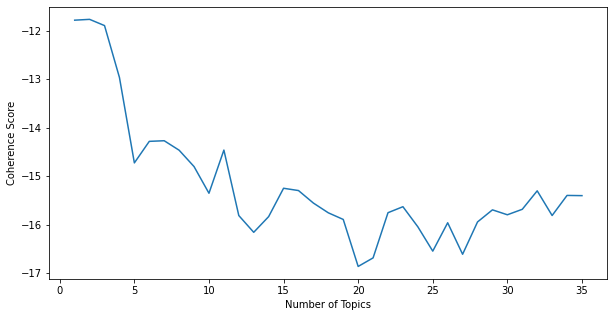

In [6]:
# Finding the number of topics using LDA(Latent Dirichlet Allocation)
# build a dictionary where for each tweet, each word has its own id.
# We have **** tweets and **** words in the dictionary.
tweets_dictionary = Dictionary(df_tweets_clean.tokenized_text)

# build the corpus i.e. vectors with the number of occurence of each word per tweet
tweets_corpus = [tweets_dictionary.doc2bow(tweet) for tweet in df_tweets_clean.tokenized_text]

# compute coherence
tweets_coherence = []
for nb_topics in range(1,36):
    lda = LdaModel(tweets_corpus, num_topics = nb_topics, id2word = tweets_dictionary, passes=10)
    cohm = CoherenceModel(model=lda, corpus=tweets_corpus, dictionary=tweets_dictionary, coherence='u_mass')
    coh = cohm.get_coherence()
    tweets_coherence.append(coh)

# visualize coherence
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
plt.plot(range(1,36),tweets_coherence)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score");

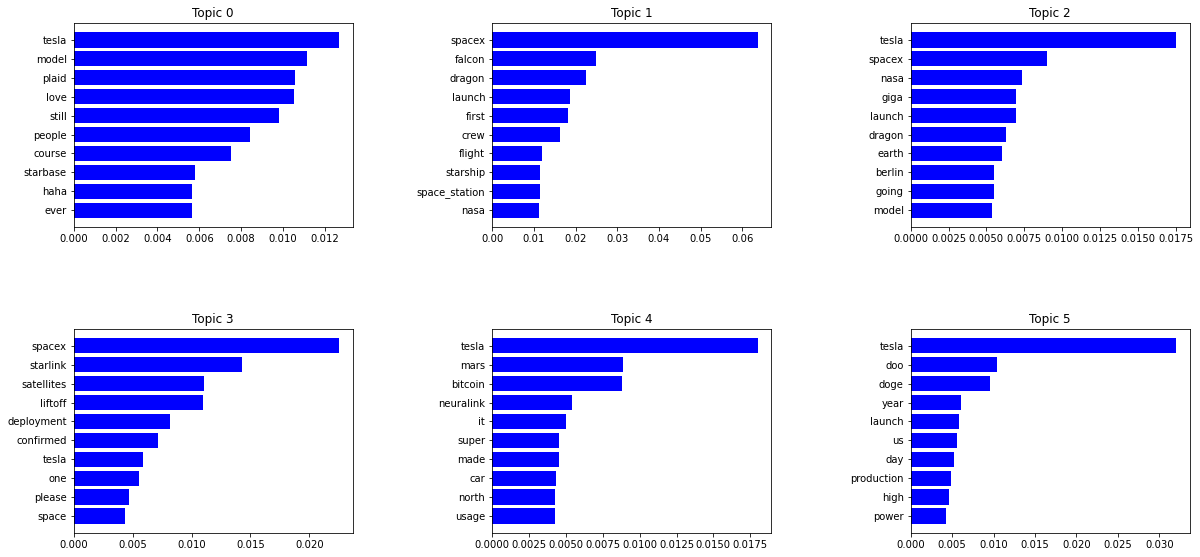

In [7]:
# Running LDA and the top 10 words for each of the topics 
import matplotlib.gridspec as gridspec
k = 6
tweets_lda = LdaModel(tweets_corpus, num_topics = k, id2word = tweets_dictionary, passes=10)

def plot_top_words(lda=tweets_lda, nb_topics=k, nb_words=10):
    top_words = [[word for word,_ in lda.show_topic(topic_id, topn=50)] for topic_id in range(lda.num_topics)]
    top_betas = [[beta for _,beta in lda.show_topic(topic_id, topn=50)] for topic_id in range(lda.num_topics)]

    gs  = gridspec.GridSpec(round(math.sqrt(k))+1,round(math.sqrt(k))+1)
    gs.update(wspace=0.5, hspace=0.5)
    plt.figure(figsize=(20,15))
    for i in range(nb_topics):
        ax = plt.subplot(gs[i])
        plt.barh(range(nb_words), top_betas[i][:nb_words], align='center',color='blue', ecolor='black')
        ax.invert_yaxis()
        ax.set_yticks(range(nb_words))
        ax.set_yticklabels(top_words[i][:nb_words])
        plt.title("Topic "+str(i))
        
  
plot_top_words()